In [1]:

! pip install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu113
! pip install gym-super-mario-bros opencv-python numpy tqdm
! pip install mediapy scipy
! pip install gym


Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu113


# PPO Algorithm

In [2]:
import torch
import torch.nn as nn
from torch.distributions import MultivariateNormal
from torch.distributions import Categorical
from nes_py.wrappers import JoypadSpace
import gym_super_mario_bros
from gym_super_mario_bros.actions import SIMPLE_MOVEMENT,COMPLEX_MOVEMENT
from datetime import datetime
import cv2
from tqdm import tqdm
import numpy as np
from gym.wrappers import GrayScaleObservation

In [3]:
# set device to cpu or cuda
device = torch.device('cpu')
if(torch.cuda.is_available()):
    device = torch.device('cuda:0')
    torch.cuda.empty_cache()
    print("Device set to : " + str(torch.cuda.get_device_name(device)))

else:
    print("Device set to : cpu")
    raise ValueError("No GPU is set")

Device set to : Quadro P4000


## Actor critic

In [4]:
# The RolloutBuffer which keeps the training tuples.
class RolloutBuffer:
    def __init__(self):
        self.actions = []
        self.states = []
        self.logprobs = []
        self.rewards = []
        self.is_terminals = []

    # We clear the buffer after each training update
    def clear(self):
        del self.actions[:]
        del self.states[:]
        del self.logprobs[:]
        del self.rewards[:]
        del self.is_terminals[:]

In [5]:
class ActorCritic(nn.Module):
    def __init__(self, state_dim, action_dim, has_continuous_action_space, action_std_init):
        super(ActorCritic, self).__init__()
        # We define if the action space is continuous or a value choosen from a set of possible actions
        self.has_continuous_action_space = has_continuous_action_space


        if has_continuous_action_space:
            self.action_dim = action_dim
            self.action_var = torch.full((action_dim,), action_std_init * action_std_init).to(device)
        # defining the actor
        if has_continuous_action_space :
            self.actor = nn.Sequential(
                            nn.Linear(state_dim, 64),
                            nn.Tanh(),
                            nn.Linear(64, 64),
                            nn.Tanh(),
                            nn.Linear(64, action_dim),
                        )
        else:
            self.actor = nn.Sequential(
                            nn.Linear(state_dim, 64),
                            nn.Tanh(),
                            nn.Linear(64, 64),
                            nn.Tanh(),
                            nn.Linear(64, action_dim),
                            nn.Softmax(dim=-1)
                        )
        # defining the critic
        self.critic = nn.Sequential(
                        nn.Linear(state_dim, 64),
                        nn.Tanh(),
                        nn.Linear(64, 64),
                        nn.Tanh(),
                        nn.Linear(64, 1)
                    )

    def set_action_std(self, new_action_std):
        #We only calculate the action std if we have a continuous action space
        if self.has_continuous_action_space:
            self.action_var = torch.full((self.action_dim,), new_action_std * new_action_std).to(device)
        else:
            print("--------------------------------------------------------------------------------------------")
            print("WARNING : Calling ActorCritic::set_action_std() on discrete action space policy")
            print("--------------------------------------------------------------------------------------------")

    def forward(self):
        raise NotImplementedError

    def act(self, state):
        # if we have a continuous action space we sample from a multivariate normal distribution
        # otherwise we calculate a categorical action spac
        if self.has_continuous_action_space:
            action_mean = self.actor(state)
            cov_mat = torch.diag(self.action_var).unsqueeze(dim=0)
            dist = MultivariateNormal(action_mean, cov_mat)
        else:
            action_probs = self.actor(state)
            dist = Categorical(action_probs)

        action = dist.sample()
        action_logprob = dist.log_prob(action)

        return action.detach(), action_logprob.detach()

    def evaluate(self, state, action):

        if self.has_continuous_action_space:
            action_mean = self.actor(state)

            action_var = self.action_var.expand_as(action_mean)
            cov_mat = torch.diag_embed(action_var).to(device)
            dist = MultivariateNormal(action_mean, cov_mat)

            # For Single Action Environments.
            if self.action_dim == 1:
                action = action.reshape(-1, self.action_dim)
        else:
            action_probs = self.actor(state)
            dist = Categorical(action_probs)
        action_logprobs = dist.log_prob(action)
        dist_entropy = dist.entropy()
        state_values = self.critic(state)

        return action_logprobs, state_values, dist_entropy


In [6]:
class PPO:
    def __init__(self, state_dim, action_dim, lr_actor, lr_critic, gamma, K_epochs, eps_clip, has_continuous_action_space, action_std_init=0.6):

        self.has_continuous_action_space = has_continuous_action_space

        if has_continuous_action_space:
            self.action_std = action_std_init

        self.gamma = gamma
        self.eps_clip = eps_clip
        self.K_epochs = K_epochs

        self.buffer = RolloutBuffer()

        self.policy = ActorCritic(state_dim, action_dim, has_continuous_action_space, action_std_init).to(device)
        self.optimizer = torch.optim.Adam([
                        {'params': self.policy.actor.parameters(), 'lr': lr_actor},
                        {'params': self.policy.critic.parameters(), 'lr': lr_critic}
                    ])

        self.policy_old = ActorCritic(state_dim, action_dim, has_continuous_action_space, action_std_init).to(device)
        self.policy_old.load_state_dict(self.policy.state_dict())

        self.MseLoss = nn.MSELoss()

    def set_action_std(self, new_action_std):
        if self.has_continuous_action_space:
            self.action_std = new_action_std
            self.policy.set_action_std(new_action_std)
            self.policy_old.set_action_std(new_action_std)
        else:
            print("--------------------------------------------------------------------------------------------")
            print("WARNING : Calling PPO::set_action_std() on discrete action space policy")
            print("--------------------------------------------------------------------------------------------")

    def decay_action_std(self, action_std_decay_rate, min_action_std):
        print("--------------------------------------------------------------------------------------------")
        if self.has_continuous_action_space:
            self.action_std = self.action_std - action_std_decay_rate
            self.action_std = round(self.action_std, 4)
            if (self.action_std <= min_action_std):
                self.action_std = min_action_std
                print("setting actor output action_std to min_action_std : ", self.action_std)
            else:
                print("setting actor output action_std to : ", self.action_std)
            self.set_action_std(self.action_std)

        else:
            print("WARNING : Calling PPO::decay_action_std() on discrete action space policy")
        print("--------------------------------------------------------------------------------------------")

    def select_action(self, state):

        if self.has_continuous_action_space:
            with torch.no_grad():
                state = torch.FloatTensor(state).to(device)
                action, action_logprob = self.policy_old.act(state)

            self.buffer.states.append(state)
            self.buffer.actions.append(action)
            self.buffer.logprobs.append(action_logprob)

            return action.detach().cpu().numpy().flatten()
        else:
            with torch.no_grad():
                state = torch.FloatTensor(state).to(device)
                action, action_logprob = self.policy_old.act(state)

            self.buffer.states.append(state)
            self.buffer.actions.append(action)
            self.buffer.logprobs.append(action_logprob)

            return action.item()

    def update(self):
        # Monte Carlo estimate of returns
        rewards = []
        discounted_reward = 0
        for reward, is_terminal in zip(reversed(self.buffer.rewards), reversed(self.buffer.is_terminals)):
            if is_terminal:
                discounted_reward = 0
            discounted_reward = reward + (self.gamma * discounted_reward)
            rewards.insert(0, discounted_reward)

        # Normalizing the rewards
        rewards = torch.tensor(rewards, dtype=torch.float32).to(device)
        rewards = (rewards - rewards.mean()) / (rewards.std() + 1e-7)

        # convert list to tensor
        old_states = torch.squeeze(torch.stack(self.buffer.states, dim=0)).detach().to(device)
        old_actions = torch.squeeze(torch.stack(self.buffer.actions, dim=0)).detach().to(device)
        old_logprobs = torch.squeeze(torch.stack(self.buffer.logprobs, dim=0)).detach().to(device)

        # Optimize policy for K epochs
        for _ in range(self.K_epochs):

            # Evaluating old actions and values
            logprobs, state_values, dist_entropy = self.policy.evaluate(old_states, old_actions)

            # match state_values tensor dimensions with rewards tensor
            state_values = torch.squeeze(state_values)

            # Finding the ratio (pi_theta / pi_theta__old)
            ratios = torch.exp(logprobs - old_logprobs.detach())

            # Finding Surrogate Loss
            advantages = rewards - state_values.detach()
            surr1 = ratios * advantages
            surr2 = torch.clamp(ratios, 1-self.eps_clip, 1+self.eps_clip) * advantages

            # final loss of clipped objective PPO
            loss = -torch.min(surr1, surr2) + 0.5*self.MseLoss(state_values, rewards) - 0.01*dist_entropy

            # take gradient step
            self.optimizer.zero_grad()
            loss.mean().backward()
            self.optimizer.step()

        # Copy new weights into old policy
        self.policy_old.load_state_dict(self.policy.state_dict())

        # clear buffer
        self.buffer.clear()

    def save(self, checkpoint_path):
        torch.save(self.policy_old.state_dict(), checkpoint_path)

    def load(self, checkpoint_path):
        self.policy_old.load_state_dict(torch.load(checkpoint_path, map_location=lambda storage, loc: storage))
        self.policy.load_state_dict(torch.load(checkpoint_path, map_location=lambda storage, loc: storage))

In [7]:
! pip install ffmpeg

In [8]:
#renders given frames with mediapy and shows a video
def renderEnv(frames):
  import mediapy as media
  media.show_video(frames,fps=60//6)

#plot for visualizing results
def plotRewardandTime(avg_reward,avg_norm_reward,avg_length):
  import matplotlib.pyplot as plt
  import scipy
  from scipy.signal import savgol_filter
  x = np.linspace(0,len(avg_reward),len(avg_reward))

  fig, axs = plt.subplots(2, 2,figsize=(9,9))
  axs[0, 0].plot(x, savgol_filter(avg_reward,window_length=29,polyorder=3,mode='mirror') if len(avg_reward) > 30 else avg_reward)
  axs[0, 0].set_title("avg_reward")

  axs[0, 1].plot(x, savgol_filter(avg_norm_reward,window_length=29,polyorder=3,mode='mirror') if len(avg_norm_reward) > 30 else avg_norm_reward)
  axs[0, 1].set_title("avg_norm_reward")

  axs[1, 0].plot(x, savgol_filter(avg_length,window_length=29,polyorder=3,mode='mirror') if len(avg_length) > 30 else avg_length)
  axs[1, 0].set_title("avg_length")
  plt.show()

In [9]:
import gym

#This environment wrapper is used to stop a run if mario is stuck on a pipe
class DeadlockEnv(gym.Wrapper):
    def __init__(self, env, threshold=10):
        super().__init__(env)
        self.last_x_pos = 0
        self.count = 0
        self.threshold = threshold
        self.lifes = 3

    def reset(self, **kwargs):
        self.last_x_pos = 0
        self.count = 0
        return self.env.reset(**kwargs)

    def step(self, action):
        state, reward, done, info = self.env.step(action)
        x_pos = info['x_pos']

        if x_pos <= self.last_x_pos:
            self.count += 1
        else:
            self.count = 0
            self.last_x_pos = x_pos

        if info['life'] != self.lifes:
            self.last_x_pos = x_pos
            self.count = 0
            self.lifes = info['life']

        if self.count >= self.threshold:
            reward = -15
            done = True

        return state, reward, done, info

#skipframe wrapper
class SkipFrame(gym.Wrapper):
    def __init__(self, env, skip):
        super().__init__(env)
        self._skip = skip

    def step(self, action):
        reward_out = 0
        for i in range(self._skip):
            obs, reward, done, info = self.env.step(action)
            reward_out += reward
            if done:
                break
        reward_out /= max(1,i+1)

        return obs, reward, done, info

#downsample wrapper to reduce dimensionality
def Downsample(ratio,state):
  (oldh, oldw, oldc) = state.shape
  newshape = (oldh//ratio, oldw//ratio, oldc)
  frame = cv2.resize(state, (newshape[0], newshape[1]), interpolation=cv2.INTER_AREA)
  return frame

#small function to change rgb images to grayscale
def GrayScale(state):
  return cv2.cvtColor(state, cv2.COLOR_RGB2GRAY)



# Hyperparameter tuning

In [21]:
from IPython.core.display import clear_output
import matplotlib.pyplot as plt
import scipy
from scipy.signal import savgol_filter
#from google.colab import files
import time

def hyperparameter_tuning(config):

    print("====================================CONFIG==================================================")
    print(config)
    print("============================================================================================")

    state_dim = 15360                   # state space dimension
    lr_actor = config["lr_actor"]                     # learning rate for actor network
    lr_critic = config["lr_critic"]                     # learning rate for critic network
    gamma = config["gamma"]                          # gamma discount
    K_epochs = config["k_epochs"]                         # K value for the PPO-CLIP objective function
    eps_clip = config["eps"]                        # the epsilon clipping value
    has_continuous_action_space = False   # the mario environment doesn't have a continuous action space
    action_std = None                     # we don't change the action distribution
    frameskip = config["skip"]                        # the frameskip value of the environment
    down_sample_rate = 4                  # downsample rate. Calculated as: original_dimension/down_sample_rate
    frame_stack = 4                       # frame stacking value
    update_steps = 2048                   # how long we collect steps before updating

    env = gym_super_mario_bros.make('SuperMarioBros-v1')  #the environment. v0 is with original background, v1 has the background removed
    env = JoypadSpace(env, COMPLEX_MOVEMENT)              #The Joypadspace sets the available actions. We use COMPLEX_MOVEMENT to allow to go down in pipes.
    env = SkipFrame(env, skip=frameskip)                  #Skipframewrapper to skip some frames
    env = DeadlockEnv(env,threshold=10)                   #Deadlock environment wrapper to stop the game if mario is stuck at a pipe



    action_dim = env.action_space.n # action space dimension
    #state_dim = env.state_space.n  # Currently we flatten the input and therefore set the state_dim manually

    ppo_agent = PPO(state_dim, action_dim, lr_actor, lr_critic, gamma, K_epochs, eps_clip, has_continuous_action_space, action_std)

    # track total training time
    start_time = datetime.now().replace(microsecond=0)
    print("Started training at (GMT) : ", start_time)

    print("============================================================================================")

    #some helper variables
    time_step = 0
    max_training_epochs = 50008 #int(1e9)
    max_ep_len = 10000
    update_timestep = max_ep_len

    # We mount the google drive to save and load PPO states.
    #from google.colab import drive
    #drive.mount('/content/gdrive')

    # If an agent is saved you can uncomment the following line to load the weights.
    #ppo_agent.load("/content/gdrive/My Drive/ppo.save")

    avg_reward = []
    avg_length = []
    avg_norm_reward = []
    updates = 0
    
    flag_counter = 0
    status_counter = 0

    tbar = tqdm(range(max_training_epochs))
    for i in tbar:
        # first we reset the state
        state = env.reset()
        current_ep_reward = 0
        # as we stack some frames, we create a buffer with empty frames for the first inputs
        states_buffer = [np.zeros((3840,)) for _ in range(3)]
        frames = []
        
        last_score = -1
        last_coins = -1
        last_status = 'small'
        
        # the collection loop
        for t in range(1, max_ep_len):
            # Downsampling the environment
            in_state = GrayScale(Downsample(down_sample_rate,state.copy())).flatten()

            # creating the new stack for the current frame
            states_buffer.append(in_state)
            states_buffer = states_buffer[-frame_stack:]

            # selecting an action
            action = ppo_agent.select_action(np.asarray(states_buffer).flatten())

            # performing the action and receiving the information from the environments
            state, reward, done, info = env.step(action)
            
            #update flag_counter
            if (info['flag_get']):
                flag_counter += 1
            #update status counter:
            if (last_status == 'small' and info['status'] != 'small'):
                status_counter += 1
            last_status = info['status']
            
            
            #-----------------------------------------------------------------------------
            # Adding Alberts Reward-function shaping:
            # #### PENALTY FOR GOING UNDER BASE Y LIMIT ; should be approx 79
            #base_y_penalty = 0
            #if (info['y_pos'] < 78):
            #  base_y_penalty = -0.5
            #reward += base_y_penalty
            
            #  ### Beating Enemies
            # # Happens when Score goes up, but collected coins not
            #enemy_reward = 0
            #if last_score == -1:
            #  last_score = info['score']
            #if last_coins == -1:
            #  last_coins = info['coins']

            #if (info['score'] > last_score) and (info['coins'] <= last_coins):
            #  last_score = info['score']
            #  last_coins = info['coins'] # irrelevant update; for completeness sake
            #  enemy_reward = 0.2

            #reward += enemy_reward
            
            # ### Baseline Reward Function for reaching flag pole / axe
            #flag_reward = 0
            #if (info['flag_get']):
            #    flag_reward = 0.5

            #reward += flag_reward

            # # Status reward
            #status_reward = 0
            #if (last_status == 'small' and info['status'] != 'small'):
            #  status_reward = 0.1
            #reward += status_reward
            
            #-----------------------------------------------------------------------------
            

            # Every 50 epochs we render the environments and therefore save the state
            if i % 50 == 0 and not done:
                frames.append(state.copy())

            # The PPO agent needs the reward and the done state manually, as we could modify it.
            ppo_agent.buffer.rewards.append(reward)
            ppo_agent.buffer.is_terminals.append(done)

            time_step +=1
            current_ep_reward += reward

            # every update_steps (2048) we update the algorithm
            if time_step % update_steps == 0:
                ppo_agent.update()
                updates += 1

            # if the run is done we break the loop
            if done:
                break

        # We collect information every run and write them to the console
        avg_reward.append(current_ep_reward)
        avg_length.append(t)
        tbar.set_description("timestep: " + str(time_step) + " updates: "+str(updates)+" reward: "+str(np.asarray(avg_norm_reward[-50:]).mean()))
        avg_norm_reward.append(current_ep_reward/max(1,t))

        # Every 50 epochs we render the current environment
        if i % 50 == 0 and len(frames) > 0:
          clear_output(wait=True)
          print("--------------------------------")
          print("Epoch",i,"done:")
          print("Update iterations:",updates)
          print("Statistics:")
          print("")
          print("flag_counter: ", flag_counter)
          print("Reward for this episode:",current_ep_reward)
          print("Length of this episode:",t)
          print("")
          print("Average total reward:",np.asarray(avg_reward[-50:]).mean())
          print("Average normalized reward:",np.asarray(avg_norm_reward[-50:]).mean())
          print("Average length:",np.asarray(avg_length[-50:]).mean())
          print("Plot_lr_actor="+str(config["lr_actor"])+"__lr_critic="+str(config["lr_critic"])+"__gamma="+str(config["gamma"])+"__k_epochs="+str(config["k_epochs"]))
          print("--------------------------------")

          #plotRewardandTime(avg_reward,avg_norm_reward,avg_length)


          x = np.linspace(0,len(avg_reward),len(avg_reward))

          fig, axs = plt.subplots(2, 2,figsize=(9,9))
          axs[0, 0].plot(x, savgol_filter(avg_reward,window_length=29,polyorder=3,mode='mirror') if len(avg_reward) > 30 else avg_reward)
          axs[0, 0].set_title("avg_reward")

          axs[0, 1].plot(x, savgol_filter(avg_norm_reward,window_length=29,polyorder=3,mode='mirror') if len(avg_norm_reward) > 30 else avg_norm_reward)
          axs[0, 1].set_title("avg_norm_reward")

          axs[1, 0].plot(x, savgol_filter(avg_length,window_length=29,polyorder=3,mode='mirror') if len(avg_length) > 30 else avg_length)
          axs[1, 0].set_title("avg_length")

          
          filename = "Plot_lr_actor="+str(config["lr_actor"])+"__lr_critic="+str(config["lr_critic"])+"__gamma="+str(config["gamma"])+"__k_epochs="+str(config["k_epochs"])+"__eps="+str(config["eps"])+"__skips="+str(config["skip"])
          plt.savefig("cc_projekt/"+ "__original_configuration__" +filename +  '.jpg')
          #files.download(filename +  '.jpg')
          plt.show()



          renderEnv(frames)
          # We DONT save the first epoch, as that would be just random weights.
          #if i > 10:
            #ppo_agent.save("/content/gdrive/My Drive/ppo.save")








    env.close()
    return(ppo_agent, flag_counter)


--------------------------------
Epoch 950 done:
Update iterations: 36
Statistics:

flag_counter:  0
Reward for this episode: 259.0
Length of this episode: 140

Average total reward: 156.92
Average normalized reward: 1.773530298202783
Average length: 84.74
Plot_lr_actor=3e-05__lr_critic=1e-05__gamma=0.9__k_epochs=60
--------------------------------


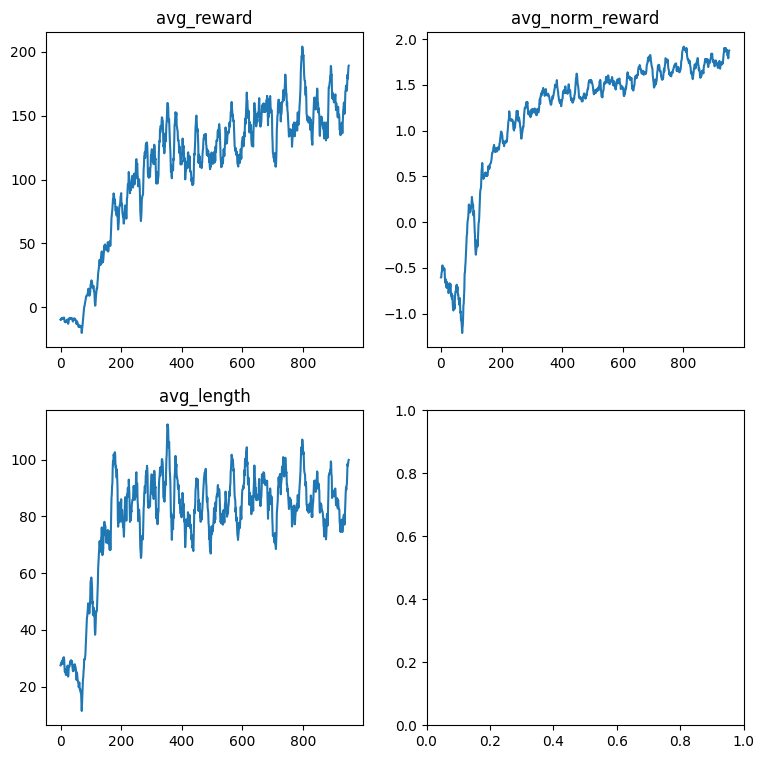

timestep: 78761 updates: 38 reward: 1.7643117218190096: 100%|█| 1000/1000 [28:39


In [18]:
import numpy as np
from PIL import Image

lr_actor = [0.00003]
lr_critic = [0.003, 0.0001, 0.00001]
gamma = [0.8, 0.9]
k_epochs = [20, 60]
eps = [0.1, 0.3]
skip = [4, 6, 8, 10]




for i in range(len(lr_actor)):
  for j in range(len(lr_critic)):
    for k in range(len(gamma)):
      for l in range(len(k_epochs)):
        for m in range(len(eps)):
            for n in range(len(skip)):
                config = {"lr_actor": lr_actor[i], "lr_critic": lr_critic[j], "gamma": gamma[k], "k_epochs": k_epochs[l], "eps": eps[m], "skip": skip[n]}
                #filename = "Plot_lr_actor="+str(config["lr_actor"])+"__lr_critic="+str(config["lr_critic"])+"__gamma="+str(config["gamma"])+"__k_epochs="+str(config["k_epochs"]+"__eps="+str(config["eps"]))
                result, flags = hyperparameter_tuning(config)
        #files.download(filename +  '.jpg')

--------------------------------
Epoch 50000 done:
Update iterations: 2716
Statistics:

flag_counter:  5
Reward for this episode: 374.0
Length of this episode: 192

Average total reward: 185.38
Average normalized reward: 1.5628694389738924
Average length: 116.6
Plot_lr_actor=0.0003__lr_critic=0.001__gamma=0.99__k_epochs=40
--------------------------------


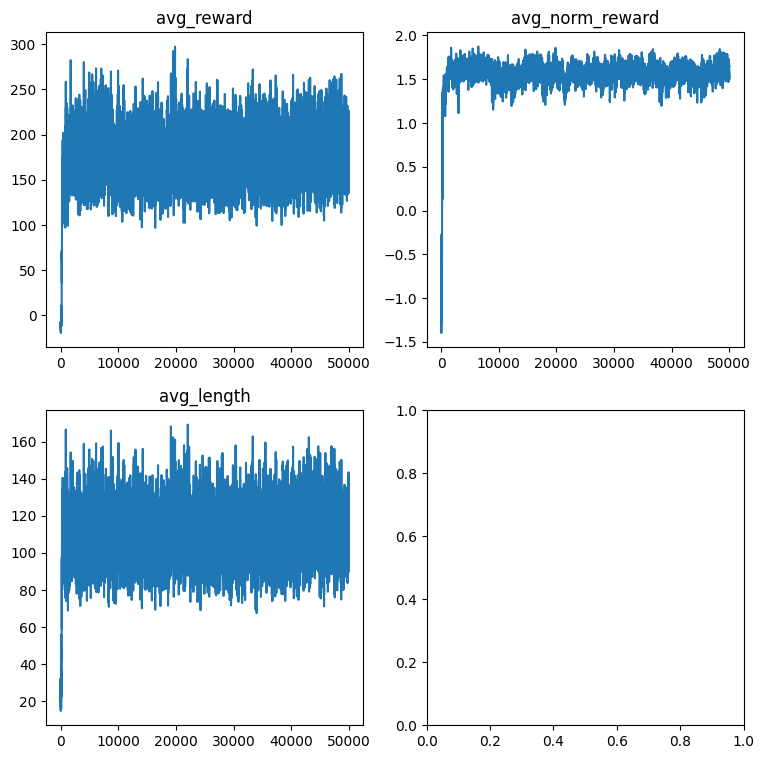

timestep: 5565046 updates: 2717 reward: 1.5574983654540417: 100%|█| 50008/50008 


In [23]:
config = {"lr_actor": 0.0003, "lr_critic": 0.001, "gamma": 0.99, "k_epochs": 40, "eps": 0.2, "skip": 6}
#filename = "Plot_lr_actor="+str(config["lr_actor"])+"__lr_critic="+str(config["lr_critic"])+"__gamma="+str(config["gamma"])+"__k_epochs="+str(config["k_epochs"])
result_ppo, flag_counter = hyperparameter_tuning(config)

In [ ]:
import numpy as np
from PIL import Image


lr_actor = [0.003, 0.0003, 0.00003]
lr_critic = [0.003, 0.001, 0.0001]
gamma = [0.8, 0.9, 0.99, 0.9997]
k_epochs = [20, 40, 60]


for i in range(len(lr_actor)):
  for j in range(len(lr_critic)):
    for k in range(len(gamma)):
      for l in range(len(k_epochs)):
        config = {"lr_actor": lr_actor[i], "lr_critic": lr_critic[j], "gamma": gamma[k], "k_epochs": k_epochs[l]}
        result = hyperparameter_tuning(config)
